# Libraries

In [162]:
# import libraries

import os
import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_auc_score

# Functions

In [163]:
# unpickle the files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [164]:
# load all CIFAR
def load_CIFAR10():

    train_images = np.zeros((50000, 32, 32, 3), dtype=np.uint8)
    train_labels = np.zeros((50000,), dtype=np.uint8)
    
    # get training data
    for i in range(5):
        train_dict = unpickle(f'./data/cifar-10-batches-py/data_batch_{i+1}')
        train_images[i*10000:(i+1)*10000] = train_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        train_labels[i*10000:(i+1)*10000] = train_dict[b'labels']

    # get testing data
    test_dict = unpickle('./data/cifar-10-batches-py/test_batch')
    test_images = test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    val_labels = np.array(test_dict[b'labels'])

    # convert from integers to floats
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')

    # scale image pixels to [0, 1]
    train_images, test_images = train_images / 255.0, test_images / 255.0

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)

    return ((train_images, train_labels), (test_images, val_labels))

In [165]:
def load_MNIST():
    (train_X, train_Y), (test_X, test_Y) = mnist.load_data()

    # scale image pixels to [0, 1]
    train_X, test_X = train_X / 255.0, test_X / 255.0

    # one hot encode target labels
    train_Y = to_categorical(train_Y)
    test_Y = to_categorical(test_Y)

    return (train_X, train_Y), (test_X, test_Y)

In [166]:
def load_Cho():

    # import cho dataset
    cols = ['Gene_ID', 'Ground_Truth_Cluster_ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']
    df_cho = pd.read_csv('./data/cho.txt', sep="	", names=cols, header=None)

    # split to 20% test set
    df_train, df_test = train_test_split(df_cho, test_size=0.2)

    # extract labels
    test_labels = df_test.iloc[:, 1].values

    # one hot encode target labels
    test_labels = to_categorical(test_labels)

    # remove first column (label 0, which is not used)
    test_labels = np.delete(test_labels, 0, axis=1)

    # reshape test for CNN
    test = np.reshape(df_test.values.astype('float32'), (df_test.shape[0], 3, 6, 1))

    return df_train, df_test, test, test_labels

In [167]:
def validation_CIFAR(images, labels):
    images, images_val, labels, labels_val = train_test_split(images, labels, test_size=0.1)

    print(f"New training/labels length: {len(images)}/{len(labels)}")
    print(f"New validation/labels length: {len(images_val)}/{len(labels_val)}")
    
    return ((images, labels), (images_val, labels_val))

In [168]:
def validation_MNIST(images, labels):
    images, images_val, labels, labels_val = train_test_split(images, labels, test_size=0.1)

    print(f"New training/labels length: {len(images)}/{len(labels)}")
    print(f"New validation/labels length: {len(images_val)}/{len(labels_val)}")
    
    return ((images, labels), (images_val, labels_val))

In [169]:
def validation_Cho(df, k):
    kf = KFold(n_splits=k, shuffle=True)
 
    # extract the fold
    for train_index, test_index in kf.split(df):
        train_data = df.iloc[train_index].values
        train_labels = df.iloc[train_index]
        val_data = df.iloc[test_index].values
        val_labels = df.iloc[test_index]

    # reshape data for CNN
    train_data = np.reshape(train_data.astype('float32'), (train_data.shape[0], 3, 6, 1))
    val_data = np.reshape(val_data.astype('float32'), (val_data.shape[0], 3, 6, 1))

    # extract labels
    train_labels = train_labels.iloc[:, 1].values
    val_labels = val_labels.iloc[:, 1].values

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    
    # remove first column (label 0, which is not used)
    train_labels = np.delete(train_labels, 0, axis=1)
    val_labels = np.delete(val_labels, 0, axis=1)

    print(f"New training/labels length: {len(train_data)}/{len(train_labels)}")
    print(f"New validation/labels length: {len(val_data)}/{len(val_labels)}")
    
    return (train_data, train_labels), (val_data, val_labels)

In [170]:
# (shape of the data, and the number of labels)
def build_model_CNN_baseline(shape, labels_size):
   
    # baseline 1-block VGG-style model
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(labels_size, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # show summary 
    print("Baseline Model Created!")
    #model.summary()
    return model

In [171]:
# (shape of the data, and the number of labels)
def build_model_CNN_tuned(shape, labels_size):

    # baseline 1-block VGG-style model + drop regularization + batch normalization
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(labels_size, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # show summary 
    print("Tuned Model Created!")
    #model.summary()
    return model

In [172]:
def verify_CIFAR(data, labels):

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # show img
        plt.imshow(data[i], cmap=plt.cm.binary)
        
        # show label
        index = np.argmax(labels[i]).astype(int) # needed after one-hot encoding
        plt.xlabel(class_names[index])
        
    plt.show()

In [173]:
def verify_MNIST(data, labels):
    for i in range(9):  
        plt.subplot(330 + 1 + i)
        plt.imshow(data[i], cmap=plt.get_cmap('gray'))
        plt.show()

In [174]:
# plot diagnostic learning curves (History object, string data name, and string indicating validaiton or test set)
# graph showing loss & accuracy over the number of epochs
def show_diagnostics(history, dataset_name, val_or_test):

    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label=val_or_test)
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label=val_or_test)
    
    # adjust visuals
    plt.suptitle('CNN - ' + dataset_name)
    plt.subplots_adjust(hspace=0.5)
    plt.legend()

    # save plot to file
    plt.show()
    #filename = os.getcwd()
    #plt.savefig(filename + '_' + dataset_name + '_evaluation.png')
    plt.close()

In [175]:
def normalize_Cho(df):
    # normalize dataset

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # PCA with n = 3
    pca = PCA(n_components=3).fit(scaled_data)
    print('Explained Variance Ratio: ', pca.explained_variance_ratio_)
    print('Sum of variance by these 3 components: ', pca.explained_variance_ratio_.cumsum()[2])
    print('\nSingular Values: ', pca.singular_values_)

    df_3D = pca.transform(scaled_data)

    return df_3D

# Run on CIFAR-10

Iteration 1:

Verifying Data...
Data Verified!

------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 45000/45000
New validation/labels length: 5000/5000
Validation Set Created!

------------------------------------------------------------------
Building Model...
Baseline Model Created!
Model Built!

------------------------------------------------------------------
Fitting Model...
Model Fitted!



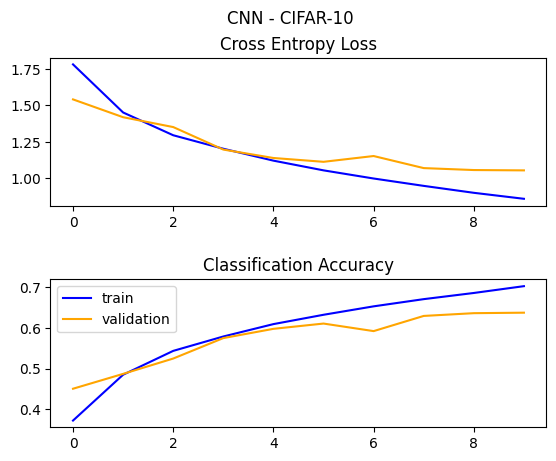

157/157 [==============================] - 2s 13ms/step - loss: 1.0540 - accuracy: 0.6376
Loss:  1.054004192352295
Validation Accuracy: 63.76%
------------------------------------------------------------------
Evaluating Model...
313/313 [==============================] - 4s 13ms/step - loss: 1.0499 - accuracy: 0.6337
Accuracy: 63.37%
F1 Score: 63.04%
AUC Score: 93.87%


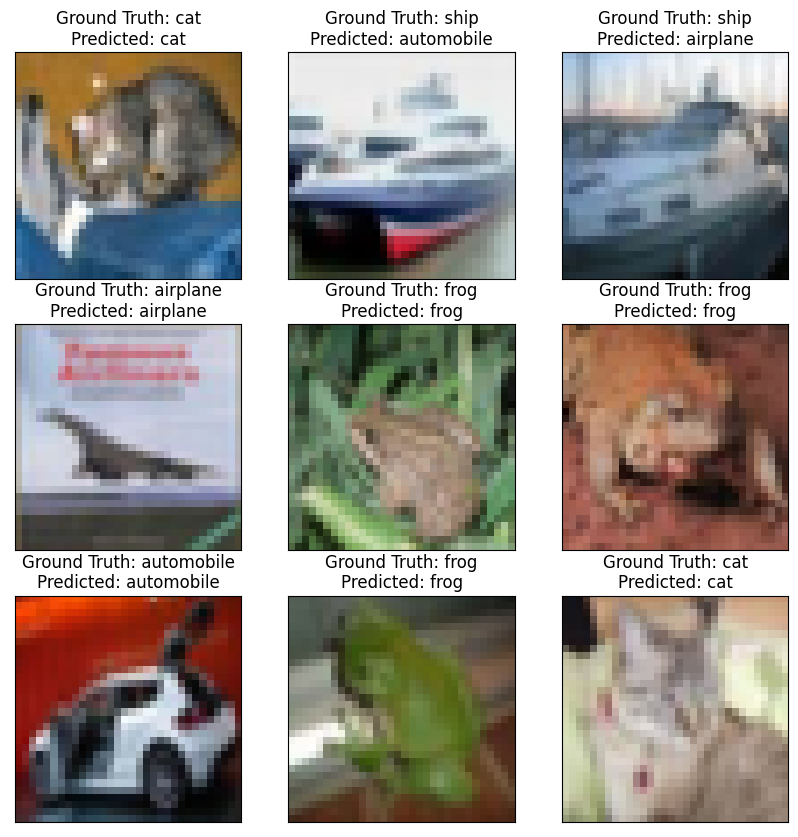


Run Complete!

Iteration 2:

Verifying Data...
Data Verified!

------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 45000/45000
New validation/labels length: 5000/5000
Validation Set Created!

------------------------------------------------------------------
Building Model...


c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Tuned Model Created!
Model Built!

------------------------------------------------------------------
Fitting Model...
Model Fitted!



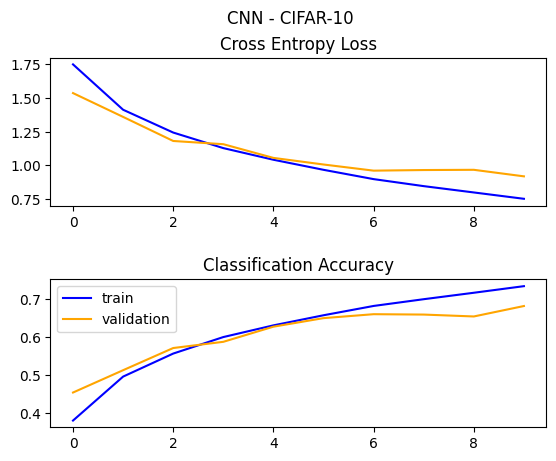

157/157 [==============================] - 2s 15ms/step - loss: 0.9193 - accuracy: 0.6824
Loss:  0.919345498085022
Validation Accuracy: 68.24%
------------------------------------------------------------------
Evaluating Model...
313/313 [==============================] - 5s 16ms/step - loss: 0.9348 - accuracy: 0.6820
Accuracy: 68.20%
F1 Score: 67.81%
AUC Score: 94.71%


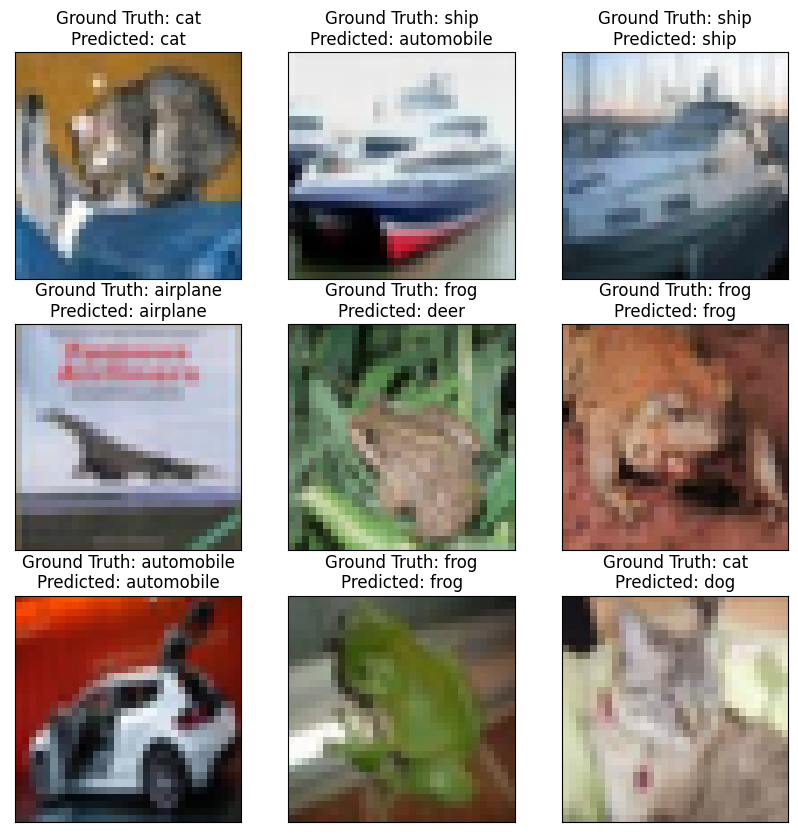


Run Complete!

Iteration 3:

Verifying Data...
Data Verified!

------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 45000/45000
New validation/labels length: 5000/5000
Validation Set Created!

------------------------------------------------------------------
Building Model...
Tuned Model Created!
Model Built!

------------------------------------------------------------------
Fitting Model...


c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Fitted!



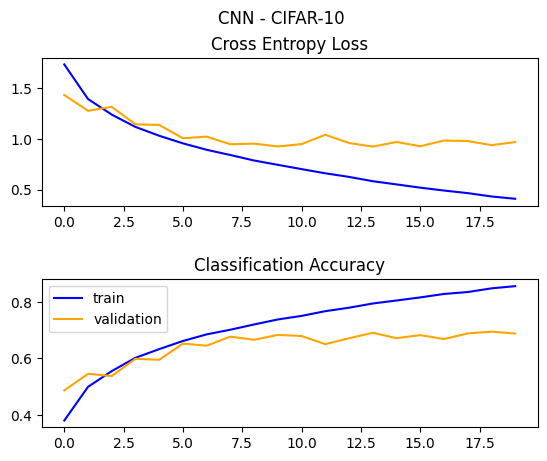

157/157 [==============================] - 3s 17ms/step - loss: 0.9691 - accuracy: 0.6876
Loss:  0.9690877795219421
Validation Accuracy: 68.76%
------------------------------------------------------------------
Evaluating Model...
313/313 [==============================] - 7s 22ms/step - loss: 0.9938 - accuracy: 0.6852
Accuracy: 68.52%
F1 Score: 68.21%
AUC Score: 94.95%


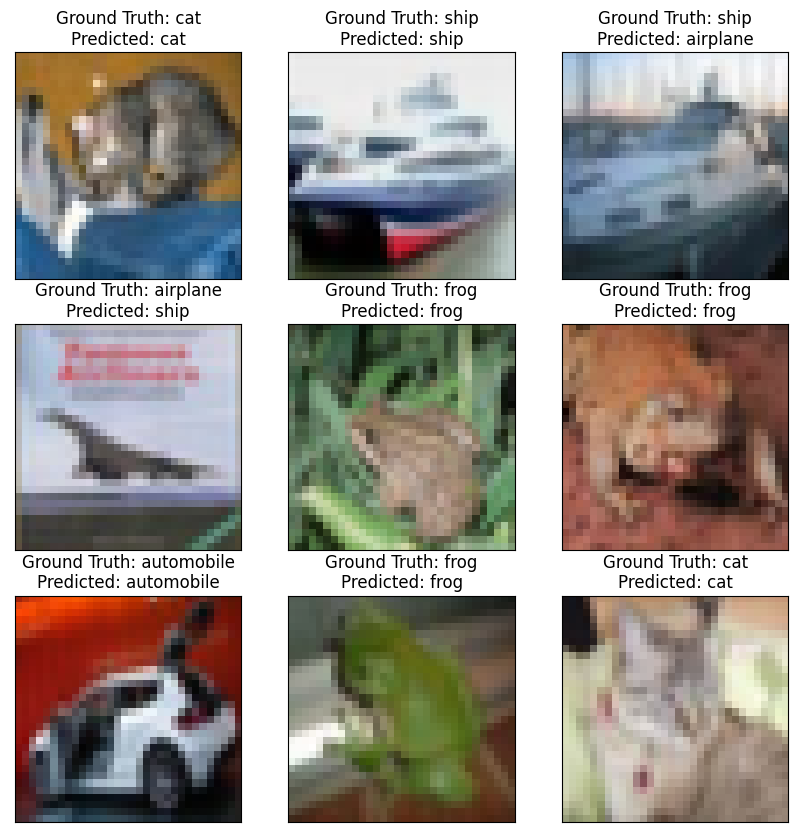


Run Complete!

Iteration 4:

Verifying Data...
Data Verified!

------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 45000/45000
New validation/labels length: 5000/5000
Validation Set Created!

------------------------------------------------------------------
Building Model...


c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Tuned Model Created!
Model Built!

------------------------------------------------------------------
Fitting Model...
Model Fitted!



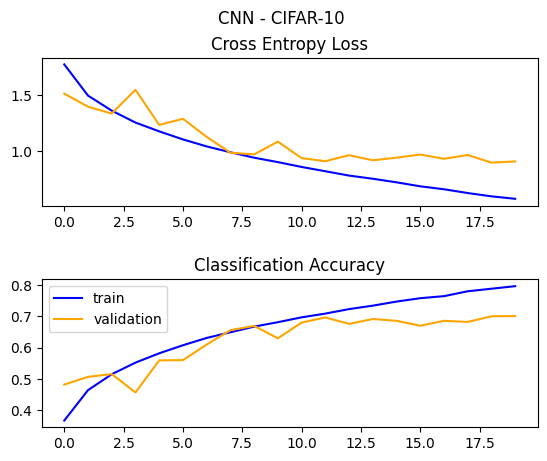

157/157 [==============================] - 3s 17ms/step - loss: 0.9054 - accuracy: 0.7010
Loss:  0.9054421186447144
Validation Accuracy: 70.10%
------------------------------------------------------------------
Evaluating Model...
313/313 [==============================] - 5s 17ms/step - loss: 0.9495 - accuracy: 0.6838
Accuracy: 68.38%
F1 Score: 68.06%
AUC Score: 95.04%


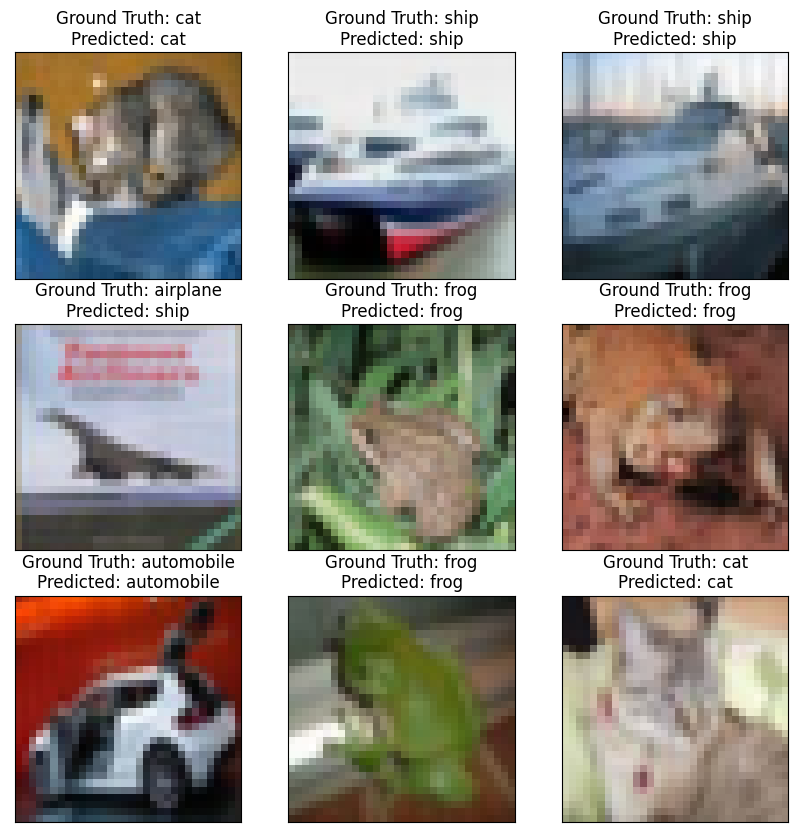


Run Complete!



In [176]:
def run_CIFAR10(epoch, batch, iteration):
    (train_data, train_labels), (test_data, test_labels) = load_CIFAR10()

    print("\nVerifying Data...")

    #verify_CIFAR(train_data, train_labels)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")
    print("Creating Validation Set...")

    (train_data, train_labels), (validation_data, validation_labels) = validation_CIFAR(train_data, train_labels)

    print("Validation Set Created!\n")
    print("------------------------------------------------------------------")
    print("Building Model...")

    if (iteration > 1):
        model_CIFAR = build_model_CNN_tuned((32, 32, 3), 10)
    else:
        model_CIFAR = build_model_CNN_baseline((32, 32, 3), 10)

    print("Model Built!\n")
    print("------------------------------------------------------------------")
    print("Fitting Model...")

    history_CIFAR10 = model_CIFAR.fit(train_data, train_labels, epochs=epoch, batch_size=batch, validation_data=(validation_data, validation_labels), verbose=0)

    print("Model Fitted!\n")

    # show learning curves
    show_diagnostics(history_CIFAR10, "CIFAR-10", "validation")

    # evaluate model
    test_loss, test_acc = model_CIFAR.evaluate(validation_data,  validation_labels)
    print("Loss: ", test_loss)
    print(f"Validation Accuracy: {test_acc :.2%}") # 45.07%

    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # make prediction of test set
    pred_labels = model_CIFAR.predict(test_data)
    df_pred = np.argmax(pred_labels, axis=1)
    df_test = np.argmax(test_labels, axis=1)

    # evaluate model
    _, acc = model_CIFAR.evaluate(test_data,  test_labels)
    f1 = f1_score(df_test, df_pred, average='macro')
    auc = roc_auc_score(df_test, pred_labels, multi_class='ovo')

    print(f"Accuracy: {acc :.2%}")
    print(f"F1 Score: {f1 :.2%}")
    print(f"AUC Score: {auc :.2%}")

    # visualize first 9 images in test set with their predicted and true labels
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(test_data[i])
        ax.set_xticks([])
        ax.set_yticks([])
        index = np.argmax(test_labels[i]).astype(int) # needed after one-hot encoding
        ax.set_title("Ground Truth: {}\nPredicted: {}".format(class_names[index], class_names[np.argmax(pred_labels[i])]))
    plt.show()
    
    print("\nRun Complete!\n")
    return

print('Iteration 1:')
run_CIFAR10(10, 64, 1)

print('Iteration 2:')
run_CIFAR10(10, 64, 2)

print('Iteration 3:')
run_CIFAR10(20, 64, 3)

print('Iteration 4:')
run_CIFAR10(20, 100, 4)

# Run on MNIST

In [177]:
""" #def run_MNIST(epoch, batch):
epoch = 30 
batch = 64
for i in range(1, 2):
    # load dataset
    (train_images, train_labels), (test_images, test_labels) = load_MNIST()

    print("\nVerifying Data...")

    #verify_MNIST(train_images, train_labels)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")
    print("Creating Validation Set...")

    (train_images, train_labels), (validation_images, validation_labels) = validation_CIFAR(train_images, train_labels)

    print("Validation Set Created!\n")
    print("------------------------------------------------------------------")
    print("Building Model...")

    if(i == 0):
        model_MNIST = build_model_CNN_baseline((28, 28, 1), 10)
    if(i == 1):
        model_MNIST = build_model_CNN_tuned((28, 28, 1), 10)

    print("Model Built!\n")
    print("------------------------------------------------------------------")
    print("Fitting Model...")

    # fit model
    history_MNIST = model_MNIST.fit(train_images, train_labels, epochs=epoch, batch_size=batch, validation_data=(validation_images, validation_labels), verbose=0)

    # show learning curves
    show_diagnostics(history_MNIST, "MNIST", "test")

    # evaluate model
    test_loss, test_acc = model_MNIST.evaluate(validation_images,  validation_labels)
    print("Loss: ", test_loss)
    print(f"Validation Accuracy: {test_acc :.2%}")

    print("Model Fitted!\n")
    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # make prediction of test set
    pred_labels = model_MNIST.predict(test_images)
    df_pred = np.argmax(pred_labels, axis=1)
    df_test = np.argmax(test_labels, axis=1)

    # evaluate model
    _, acc = model_MNIST.evaluate(test_images,  test_labels)
    f1 = f1_score(df_test, df_pred, average='macro')
    auc = roc_auc_score(df_test, pred_labels, multi_class='ovo')

    print(f"Accuracy: {acc :.2%}")
    print(f"F1 Score: {f1 :.2%}")
    print(f"AUC Score: {auc :.2%}")

    # visualize first 9 images in test set with their predicted and true labels
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(test_images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        index = np.argmax(test_labels[i]).astype(int) # needed after one-hot encoding
        ax.set_title("Ground Truth: {}\nPredicted: {}".format(index, np.argmax(pred_labels[i])))
    plt.show()

    print("\nRun Complete!\n")

print('Iteration 1:') # 10 epochs, 64 batch size
#run_MNIST(10, 64) #debug

# I suspect that the CNN model performs well on this dataset because the images are simply contrasted in color. 
# The filter should be able to easily detect any forms and shapes that would match the training datas.
# Compared to the CIFAR-10 Dataset, these images contains less ambiguity and can be easily deciphered.  """

' #def run_MNIST(epoch, batch):\nepoch = 30 \nbatch = 64\nfor i in range(1, 2):\n    # load dataset\n    (train_images, train_labels), (test_images, test_labels) = load_MNIST()\n\n    print("\nVerifying Data...")\n\n    #verify_MNIST(train_images, train_labels)\n\n    print("Data Verified!\n")\n    print("------------------------------------------------------------------")\n    print("Creating Validation Set...")\n\n    (train_images, train_labels), (validation_images, validation_labels) = validation_CIFAR(train_images, train_labels)\n\n    print("Validation Set Created!\n")\n    print("------------------------------------------------------------------")\n    print("Building Model...")\n\n    if(i == 0):\n        model_MNIST = build_model_CNN_baseline((28, 28, 1), 10)\n    if(i == 1):\n        model_MNIST = build_model_CNN_tuned((28, 28, 1), 10)\n\n    print("Model Built!\n")\n    print("------------------------------------------------------------------")\n    print("Fitting Model...")

# Run on Cho

In [178]:
""" #def run_Cho(epochs, batch):
#debug
epochs = 100
batch = 32

# load dataset
df_train, df_test, test, test_labels = load_Cho()

print("\nVerifying Data...")

print("Training: ")
print(df_train)
print("Testing: ")
print(df_test)

print("Data Verified!\n")
print("------------------------------------------------------------------")

# 6 fold cross-validation, 2 times
# First 6 folds are baselines and second 6 folds are tuned models
# both baseline and tuned models run from epochs 20 - 25
model_Cho = {}
for j in range(1,3): # 2 iterations
    for i in range(2,7):
        print("Creating Validation Set...")

        if (i > 1): # skip k=1, 1-fold cross-validation
            (train_data, train_labels), (val_data, val_labels) = validation_Cho(df_train, i)

        print("------------------------------------------------------------------")
        print("Building Model...")

        if (j == 1):
            model_Cho[i] = build_model_CNN_baseline((3, 6, 1), 5) # 6 labels bcuz 0-5, but 0 is not used!
        else:
            model_Cho[i] = build_model_CNN_tuned((3, 6, 1), 5)

        print("------------------------------------------------------------------")
        print("Fitting Model...")

        # fit model
        history_Cho = model_Cho[i].fit(train_data, train_labels, epochs=epochs, batch_size=batch, validation_data=(val_data, val_labels), verbose=0)
        
        # show learning curves
        if (j == 1):
            show_diagnostics(history_Cho, "Cho - " + str(i) + " Fold - Baseline", "validation")
        else:
            show_diagnostics(history_Cho, "Cho - " + str(i) + " Fold - Tuned", "validation")

        print("------------------------------------------------------------------")
        print("Evaluating Model...")

        # evaluate model
        test_loss, test_acc = model_Cho[i].evaluate(val_data,  val_labels)
        print("Loss: ", test_loss)
        print(f"Accuracy: {test_acc :.2%}")
        
        print("Evaluated Model!")
        print("------------------------------------------------------------------")
        print("Predicting...")

        # predict labels
        pred_labels = model_Cho[i].predict(test) # choose best model by index
        df_pred = np.argmax(pred_labels, axis=1)

        # evaluate model
        _, acc = model_Cho[i].evaluate(test,  test_labels)
        f1 = f1_score(df_test.Ground_Truth_Cluster_ID, df_pred, average='macro')
        auc = roc_auc_score(df_test.Ground_Truth_Cluster_ID, pred_labels, multi_class='ovo')

        print(f"Accuracy: {acc :.2%}")
        print(f"F1 Score: {f1 :.2%}")
        print(f"AUC Score: {auc :.2%}")

        print(f"Fold {i} Complete!")
        print("------------------------------------------------------------------")

#run_Cho() """

' #def run_Cho(epochs, batch):\n#debug\nepochs = 100\nbatch = 32\n\n# load dataset\ndf_train, df_test, test, test_labels = load_Cho()\n\nprint("\nVerifying Data...")\n\nprint("Training: ")\nprint(df_train)\nprint("Testing: ")\nprint(df_test)\n\nprint("Data Verified!\n")\nprint("------------------------------------------------------------------")\n\n# 6 fold cross-validation, 2 times\n# First 6 folds are baselines and second 6 folds are tuned models\n# both baseline and tuned models run from epochs 20 - 25\nmodel_Cho = {}\nfor j in range(1,3): # 2 iterations\n    for i in range(2,7):\n        print("Creating Validation Set...")\n\n        if (i > 1): # skip k=1, 1-fold cross-validation\n            (train_data, train_labels), (val_data, val_labels) = validation_Cho(df_train, i)\n\n        print("------------------------------------------------------------------")\n        print("Building Model...")\n\n        if (j == 1):\n            model_Cho[i] = build_model_CNN_baseline((3, 6, 1), 5

# Predict Cho
Choose the best fitting model from model_Cho[]

In [179]:
""" # find best model's index
print(model_Cho) """

" # find best model's index\nprint(model_Cho) "

In [180]:
""" # predict labels
pred_labels = model_Cho[5].predict(test) # choose best model by index
df_pred = np.argmax(pred_labels, axis=1)

# normalize data for plotting
df_test_3D = normalize_Cho(df_test)

# set 3 axis
Xax = df_test_3D[:,0]
Yax = df_test_3D[:,1]
Zax = df_test_3D[:,2]

# create figure variables
fig = plt.figure(figsize=(20,20), constrained_layout=False)
ax_truth = fig.add_subplot(1,3,1, projection='3d')
ax_pred = fig.add_subplot(1,3,2, projection='3d')
fig.patch.set_facecolor('white')
cdict = {0:'m', 1:'c', 2:'r', 3:'g', 4:'b', 5:'y'}
y = df_test.Ground_Truth_Cluster_ID - 1 # minus 1 to compensate for prediction labels being 0-4

# ground truth figure
for l in np.unique(y):
    i = np.where(y==l)
    ax_truth.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l], s=20, alpha=0.75, label=l)

ax_truth.set_xlabel("PC1", fontsize=14)
ax_truth.set_ylabel("PC2", fontsize=14)
ax_truth.set_zlabel("PC3", fontsize=14)
ax_truth.set_title('Cho - Ground Truth')

# predicted figure
for l in np.unique(df_pred):
    i = np.where(y==l)
    ax_pred.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l], s=20, alpha=0.75, label=l)

ax_pred.set_xlabel("PC1", fontsize=14)
ax_pred.set_ylabel("PC2", fontsize=14)
ax_pred.set_zlabel("PC3", fontsize=14)
ax_pred.set_title('Cho - Predicted Classification')

plt.legend()
plt.show()
plt.close() """

' # predict labels\npred_labels = model_Cho[5].predict(test) # choose best model by index\ndf_pred = np.argmax(pred_labels, axis=1)\n\n# normalize data for plotting\ndf_test_3D = normalize_Cho(df_test)\n\n# set 3 axis\nXax = df_test_3D[:,0]\nYax = df_test_3D[:,1]\nZax = df_test_3D[:,2]\n\n# create figure variables\nfig = plt.figure(figsize=(20,20), constrained_layout=False)\nax_truth = fig.add_subplot(1,3,1, projection=\'3d\')\nax_pred = fig.add_subplot(1,3,2, projection=\'3d\')\nfig.patch.set_facecolor(\'white\')\ncdict = {0:\'m\', 1:\'c\', 2:\'r\', 3:\'g\', 4:\'b\', 5:\'y\'}\ny = df_test.Ground_Truth_Cluster_ID - 1 # minus 1 to compensate for prediction labels being 0-4\n\n# ground truth figure\nfor l in np.unique(y):\n    i = np.where(y==l)\n    ax_truth.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l], s=20, alpha=0.75, label=l)\n\nax_truth.set_xlabel("PC1", fontsize=14)\nax_truth.set_ylabel("PC2", fontsize=14)\nax_truth.set_zlabel("PC3", fontsize=14)\nax_truth.set_title(\'Cho - Ground T